# Music Recommendation System
## Part 1: Data Pipeline & Preprocessing

This notebook handles the **data collection, exploration, and preprocessing** phase of our Music Recommendation System. We'll prepare clean, tokenized lyrics data that will be used for building recommendation models in Part 2.

### Pipeline Overview

```
Raw Data (Kaggle) → Load → Explore → Clean → Tokenize → Save Processed Data
```

---

## Table of Contents

- [1. Environment Setup](#1-environment-setup)
- [2. Import Libraries](#2-import-libraries)
- [3. Data Collection](#3-data-collection)
- [4. Data Exploration](#4-data-exploration--understanding)
- [5. Data Preprocessing](#5-data-preprocessing)
- [6. Save Cleaned Dataset](#6-save-cleaned-dataset)

### Dataset Information
- **Source**: Spotify Million Song Dataset (Kaggle)
- **Size**: ~57,650 songs
- **Features**: Artist, Song Title, Lyrics, Link

---

## 1. Environment Setup 

First, we need to install all the required libraries for this project:

- **faiss-cpu**: Facebook AI Similarity Search for efficient similarity search
- **kaggle**: API to download datasets from Kaggle
- **numpy & pandas**: Data manipulation and numerical operations
- **matplotlib**: Data visualization
- **scikit-learn**: Machine learning utilities (TF-IDF, normalization)
- **wordcloud**: Visualizing word frequencies
- **nltk**: Natural Language Toolkit for text preprocessing


In [26]:
!pip install faiss-cpu kaggle numpy pandas matplotlib scikit-learn wordcloud nltk gensim -q

## 2. Import Libraries 

Importing all necessary libraries for:
- **File & Data Operations**: `os`, `json`, `numpy`, `pandas`
- **Text Processing**: `re`, `nltk` (stopwords, tokenization)
- **Machine Learning**: `sklearn` (TF-IDF, cosine similarity, normalization)
- **Visualization**: `matplotlib`, `wordcloud`
- **Vector Search**: `faiss` for efficient similarity search
- **Model Persistence**: `joblib` for saving/loading models

In [27]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## 3. Data Collection 

We're using the **Spotify Million Song Dataset** from Kaggle, which contains song lyrics along with artist and song information.

### 3.1 Configure Kaggle API

Load Kaggle credentials from `kaggle.json` file. You need to:
1. Create a Kaggle account
2. Go to Settings → API → Create New Token
3. Save the downloaded `kaggle.json` file in the project root

In [28]:
kaggle_config = json.load(open('../kaggle.json'))
kaggle_config.keys()

dict_keys(['username', 'key'])

In [29]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

### 3.2 Download Dataset

Download the Spotify Million Song Dataset using Kaggle CLI. The dataset will be saved to the `./data` directory.


In [30]:
!kaggle datasets download notshrirang/spotify-million-song-dataset -p ../data/raw --unzip

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0




  0%|          | 0.00/20.7M [00:00<?, ?B/s]
100%|██████████| 20.7M/20.7M [00:00<00:00, 247MB/s]


### 3.3 Load Dataset

Load the downloaded CSV file into a pandas DataFrame for exploration and processing.

In [31]:
df = pd.read_csv('../data/raw/spotify_millsongdata.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


## 4. Data Exploration & Understanding 

Let's explore the dataset to understand its structure, size, and content quality.

### 4.1 Dataset Overview

Check the shape, data types, and basic statistics of our dataset.

In [32]:
print("Data shape: ", df.shape)
print("\nData info:")
df.info()

Data shape:  (57650, 4)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


### 4.2 Missing Values Check

Check for any missing values in the dataset that might need handling.

In [33]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

### 4.3 Top Artists Analysis

Identify the most frequently appearing artists in the dataset.

In [34]:
top_artists = df['artist'].value_counts().head(10)
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
 artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


### 4.4 Lyrics Word Cloud

Visualize the most common words in all song lyrics using a word cloud. This helps us understand the common themes and vocabulary in the dataset.

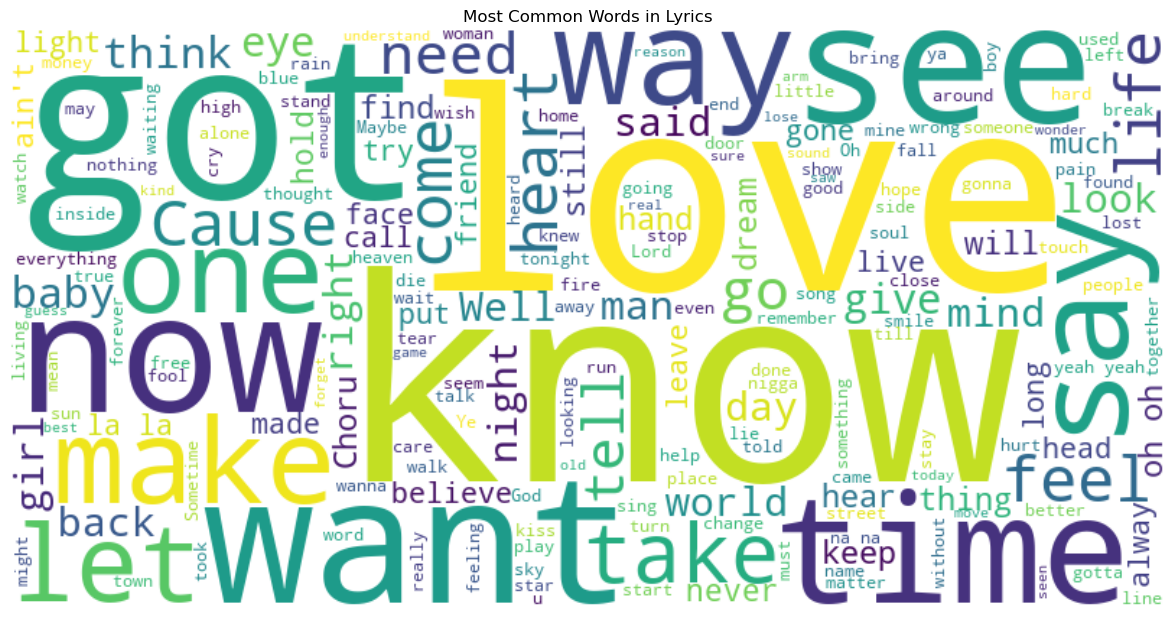

In [35]:
all_lyrics = ' '.join(df['text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

## 5. Data Preprocessing 

Text preprocessing is crucial for building an effective recommendation system. We need to clean and normalize the lyrics text.

### 5.1 Download NLTK Resources

Download the required NLTK data packages:
- **punkt**: Tokenizer models for splitting text into words
- **stopwords**: Common words (like "the", "is", "at") that we'll remove

In [36]:
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 5.2 Define Stopwords

Load the English stopwords list. These are common words that don't carry significant meaning for similarity comparison.

In [37]:
stop_words = set(stopwords.words('english'))

### 5.3 Text Preprocessing Function

Create a function to clean and normalize text:
1. **Remove special characters**: Keep only letters and spaces
2. **Convert to lowercase**: Normalize case
3. **Tokenize**: Split text into individual words
4. **Remove stopwords**: Filter out common words

In [38]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

### 5.4 Apply Preprocessing

Apply the preprocessing function to all song lyrics. This creates a new `cleaned_text` column with the processed lyrics.

In [39]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Look at her face, it's a wonderful face \r\nA...",look face wonderful face means something speci...
1,"Take it easy with me, please \r\nTouch me gen...",take easy please touch gently like summer even...
2,I'll never know why I had to go \r\nWhy I had...,ill never know go put lousy rotten show boy to...
3,Making somebody happy is a question of give an...,making somebody happy question give take learn...
4,Making somebody happy is a question of give an...,making somebody happy question give take learn...


## 6. Save Cleaned Dataset

In [40]:
df.to_csv('../data/processed/spotify_millsongdata_processed.csv', index=False)

---

##  Pipeline Complete!

### What We Accomplished
| Step | Input | Output |
|------|-------|--------|
| Data Collection | Kaggle API | `spotify_millsongdata.csv` |
| Exploration | Raw data | Understanding of data quality |
| Preprocessing | Raw lyrics | Cleaned, tokenized text |
| Export | Cleaned DataFrame | `spotify_millsongdata_processed.csv` |

### Output Files
```
data/
├── raw/
│   └── spotify_millsongdata.csv      # Original dataset
└── processed/
    └── spotify_millsongdata_processed.csv  # Cleaned lyrics
```